In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import optuna

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [29]:
# Cargar los datos
data = pd.read_csv('../../data/df_joint.csv', index_col='Date', parse_dates=True)


In [30]:
# Reemplazar las comas por puntos
data['ir_uk'] = data['ir_uk'].str.replace(',', '.')

data['ir_uk'] = data['ir_uk'].astype(float)


# EURUSD

In [31]:
# Seleccionar las características y el objetivo
features = data[['jpyusd', 'gbpusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp', 'gdp_ez', 'unrate_us', 'unrate_uk', 'unrate_jp',
       'unrate_ez', 'm0_us', 'm0_jp', 'm0_ez', 'ir_us', 'ir_uk',
       'ir_deposit_ez', 'ir_lending_ez', 'ir_MRO_ez', 'ir_jp']]
target = data['eurusd']

## Data preparation

In [33]:
# Crear la columna objetivo: 1 si el precio sube, 0 si baja
target_shifted = target.shift(-1)
target_direction = (target_shifted > target).astype(int)
target_direction = target_direction[:-1]  # Eliminar el último valor que será NaN por el shift

features = features[:-1]  # Alinear con el objetivo

# Escalar los datos
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)



(array([2501.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2455.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

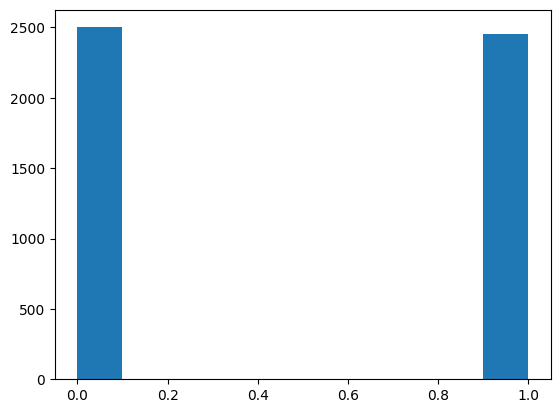

In [43]:
plt.hist(target_direction)

In [34]:
# Crear las secuencias para LSTM
def create_sequences(features, target, time_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_sequences(features_scaled, target_direction.values, time_steps)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Optuna

In [35]:
# Función de objetivo para Optuna
def objective(trial):
    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units', 50, 200), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(trial.suggest_float('dropout1', 0.2, 0.5)))
    model.add(LSTM(units=trial.suggest_int('units', 50, 200)))
    model.add(Dropout(trial.suggest_float('dropout2', 0.2, 0.5)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_float('lr', 1e-4, 1e-2)), loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=trial.suggest_int('epochs', 10, 50), batch_size=trial.suggest_int('batch_size', 16, 64), verbose=0)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy


In [36]:
# Crear el estudio Optuna y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Imprimir los mejores hiperparámetros
print(study.best_trial)

[I 2024-06-03 20:17:44,180] A new study created in memory with name: no-name-4ce74c07-79b6-4fb5-88bb-465787595ff9
c:\Users\usuario\anaconda3\envs\TFM\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-06-03 20:18:03,465] Trial 0 finished with value: 0.5060606002807617 and parameters: {'units': 194, 'dropout1': 0.4213739859852246, 'dropout2': 0.3027806917447931, 'lr': 0.004722915433103142, 'epochs': 14, 'batch_size': 36}. Best is trial 0 with value: 0.5060606002807617.
[I 2024-06-03 20:18:15,901] Trial 1 finished with value: 0.5060606002807617 and parameters: {'units': 59, 'dropout1': 0.35041127159603946, 'dropout2': 0.2653271940059672, 'lr': 0.005398649375074455, 'epochs': 26, 'batch_size': 44}. Best is trial 0 with value: 0.5060606002807617.
[I 2024-06-03 20:18:32,422

FrozenTrial(number=42, state=TrialState.COMPLETE, values=[0.508080780506134], datetime_start=datetime.datetime(2024, 6, 3, 20, 32, 41, 207222), datetime_complete=datetime.datetime(2024, 6, 3, 20, 33, 6, 639752), params={'units': 127, 'dropout1': 0.3585521140728015, 'dropout2': 0.2673911579942139, 'lr': 0.0008925887499733362, 'epochs': 37, 'batch_size': 58}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'units': IntDistribution(high=200, log=False, low=50, step=1), 'dropout1': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'dropout2': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'lr': FloatDistribution(high=0.01, log=False, low=0.0001, step=None), 'epochs': IntDistribution(high=50, log=False, low=10, step=1), 'batch_size': IntDistribution(high=64, log=False, low=16, step=1)}, trial_id=42, value=None)


## Train best model with best hyperparam

In [37]:
# Entrenar el mejor modelo con los mejores hiperparámetros
best_params = study.best_params
model = Sequential()
model.add(LSTM(units=best_params['units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(best_params['dropout1']))
model.add(LSTM(units=best_params['units']))
model.add(Dropout(best_params['dropout2']))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['lr']), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)


Epoch 1/37
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4959 - loss: 0.6977
Epoch 2/37
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4895 - loss: 0.6949
Epoch 3/37
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5037 - loss: 0.6936
Epoch 4/37
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4992 - loss: 0.6940
Epoch 5/37
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5293 - loss: 0.6926
Epoch 6/37
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5127 - loss: 0.6925
Epoch 7/37
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5012 - loss: 0.6934
Epoch 8/37
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4882 - loss: 0.6939
Epoch 9/37
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5106 - loss: 0.6940
Epoch 10/37
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4963 - loss: 0.6935
Epoch 11/37
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5138 - loss: 0.6928
Epoch 12/37
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy:

In [38]:
# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy}')


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5056 - loss: 0.6932
Model Accuracy: 0.5121212005615234


In [40]:
# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convertir las probabilidades a etiquetas binarias


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


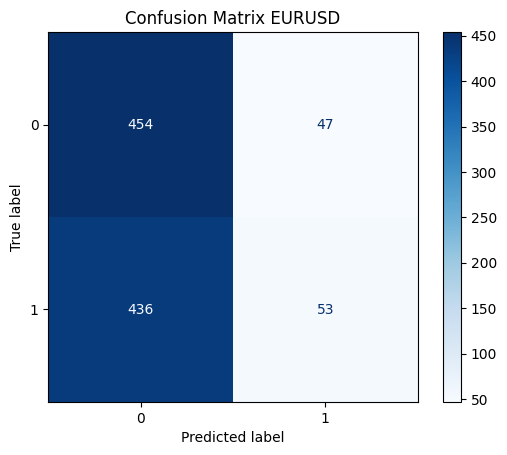

In [44]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix EURUSD')
plt.show()


# JPYUSD

In [46]:
# Seleccionar las características y los objetivos
features = data[['eurusd', 'gbpusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp', 'gdp_ez', 'unrate_us', 'unrate_uk', 'unrate_jp',
       'unrate_ez', 'm0_us', 'm0_jp', 'm0_ez', 'ir_us', 'ir_uk',
       'ir_deposit_ez', 'ir_lending_ez', 'ir_MRO_ez', 'ir_jp']]


In [47]:
# Crear la columna objetivo: 1 si el precio sube, 0 si baja
target_jpyusd = data['jpyusd']
target_shifted_jpyusd = target_jpyusd.shift(-1)
target_direction_jpyusd = (target_shifted_jpyusd > target_jpyusd).astype(int)
target_direction_jpyusd = target_direction_jpyusd[:-1]  # Eliminar el último valor que será NaN por el shift

features_jpyusd = features[:-1]  # Alinear con el objetivo

# Escalar los datos
scaler_jpyusd = MinMaxScaler()
features_scaled_jpyusd = scaler_jpyusd.fit_transform(features_jpyusd)

# Crear las secuencias para LSTM
def create_sequences(features, target, time_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X_jpyusd, y_jpyusd = create_sequences(features_scaled_jpyusd, target_direction_jpyusd.values, time_steps)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_jpyusd, X_test_jpyusd, y_train_jpyusd, y_test_jpyusd = train_test_split(X_jpyusd, y_jpyusd, test_size=0.2, shuffle=False)


In [48]:
# Función de objetivo para Optuna
def objective_jpyusd(trial):
    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units', 50, 200), return_sequences=True, input_shape=(X_train_jpyusd.shape[1], X_train_jpyusd.shape[2])))
    model.add(Dropout(trial.suggest_float('dropout1', 0.2, 0.5)))
    model.add(LSTM(units=trial.suggest_int('units', 50, 200)))
    model.add(Dropout(trial.suggest_float('dropout2', 0.2, 0.5)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_float('lr', 1e-4, 1e-2)), loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train_jpyusd, y_train_jpyusd, epochs=trial.suggest_int('epochs', 10, 50), batch_size=trial.suggest_int('batch_size', 16, 64), verbose=0)
    loss, accuracy = model.evaluate(X_test_jpyusd, y_test_jpyusd, verbose=0)
    return accuracy


In [50]:
# Crear el estudio Optuna y optimizar
study_jpyusd = optuna.create_study(direction='maximize')
study_jpyusd.optimize(objective_jpyusd, n_trials=50)

# Imprimir los mejores hiperparámetros
print(study_jpyusd.best_trial)


[I 2024-06-03 21:27:10,299] A new study created in memory with name: no-name-1e83fb98-1795-44b0-ab93-3f79a5c50f6d
c:\Users\usuario\anaconda3\envs\TFM\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-06-03 21:27:48,859] Trial 0 finished with value: 0.5292929410934448 and parameters: {'units': 161, 'dropout1': 0.2861482179117896, 'dropout2': 0.2738215476538362, 'lr': 0.0074258589250227386, 'epochs': 28, 'batch_size': 28}. Best is trial 0 with value: 0.5292929410934448.
[I 2024-06-03 21:28:33,225] Trial 1 finished with value: 0.5292929410934448 and parameters: {'units': 130, 'dropout1': 0.49398004044782556, 'dropout2': 0.4373718902249113, 'lr': 0.008705326499781738, 'epochs': 42, 'batch_size': 26}. Best is trial 0 with value: 0.5292929410934448.
[I 2024-06-03 21:29:18,3

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.5292929410934448], datetime_start=datetime.datetime(2024, 6, 3, 21, 27, 10, 300866), datetime_complete=datetime.datetime(2024, 6, 3, 21, 27, 48, 859066), params={'units': 161, 'dropout1': 0.2861482179117896, 'dropout2': 0.2738215476538362, 'lr': 0.0074258589250227386, 'epochs': 28, 'batch_size': 28}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'units': IntDistribution(high=200, log=False, low=50, step=1), 'dropout1': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'dropout2': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'lr': FloatDistribution(high=0.01, log=False, low=0.0001, step=None), 'epochs': IntDistribution(high=50, log=False, low=10, step=1), 'batch_size': IntDistribution(high=64, log=False, low=16, step=1)}, trial_id=0, value=None)


In [51]:
# Entrenar el mejor modelo con los mejores hiperparámetros
best_params_jpyusd = study_jpyusd.best_params
model_jpyusd = Sequential()
model_jpyusd.add(LSTM(units=best_params_jpyusd['units'], return_sequences=True, input_shape=(X_train_jpyusd.shape[1], X_train_jpyusd.shape[2])))
model_jpyusd.add(Dropout(best_params_jpyusd['dropout1']))
model_jpyusd.add(LSTM(units=best_params_jpyusd['units']))
model_jpyusd.add(Dropout(best_params_jpyusd['dropout2']))
model_jpyusd.add(Dense(1, activation='sigmoid'))

model_jpyusd.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_jpyusd['lr']), loss='binary_crossentropy', metrics=['accuracy'])

model_jpyusd.fit(X_train_jpyusd, y_train_jpyusd, epochs=best_params_jpyusd['epochs'], batch_size=best_params_jpyusd['batch_size'], verbose=1)


Epoch 1/28


c:\Users\usuario\anaconda3\envs\TFM\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5108 - loss: 0.7012
Epoch 2/28
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5113 - loss: 0.6939
Epoch 3/28
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5041 - loss: 0.6945
Epoch 4/28
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5068 - loss: 0.6954
Epoch 5/28
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5179 - loss: 0.6935
Epoch 6/28
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5088 - loss: 0.6936
Epoch 7/28
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5215 - loss: 0.6916
Epoch 8/28
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5047 - loss: 0.6935
Epoch 9/28
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5250 - loss: 0.6914
Epoch 10/28
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5247 - loss: 0.6928
Epoch 11/28
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5140 - loss: 0.6933
Epoch 12/28
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accurac

In [52]:
# Evaluar el modelo
loss_jpyusd, accuracy_jpyusd = model_jpyusd.evaluate(X_test_jpyusd, y_test_jpyusd)
print(f'Model Accuracy for JPY/USD: {accuracy_jpyusd}')


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5121 - loss: 0.6929
Model Accuracy for JPY/USD: 0.5292929410934448


In [53]:
# Hacer predicciones en el conjunto de prueba
y_pred_jpyusd = model_jpyusd.predict(X_test_jpyusd)
y_pred_jpyusd = (y_pred_jpyusd > 0.5).astype(int)  # Convertir las probabilidades a etiquetas binarias


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


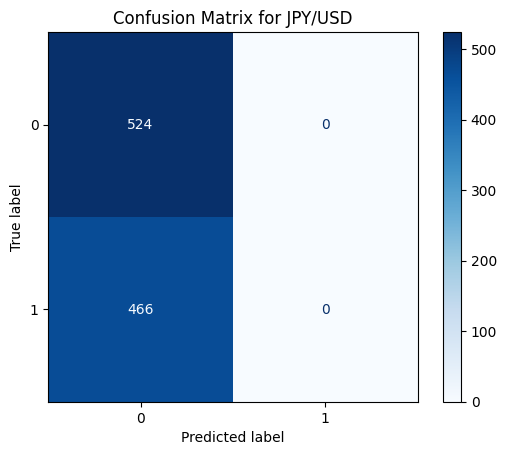

In [54]:
# Generar la matriz de confusión
cm_jpyusd = confusion_matrix(y_test_jpyusd, y_pred_jpyusd)

# Mostrar la matriz de confusión
disp_jpyusd = ConfusionMatrixDisplay(confusion_matrix=cm_jpyusd, display_labels=[0, 1])
disp_jpyusd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for JPY/USD')
plt.show()


# GBPUSD

In [58]:
# Seleccionar las características y los objetivos
features = data[['eurusd', 'jpyusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp', 'gdp_ez', 'unrate_us', 'unrate_uk', 'unrate_jp',
       'unrate_ez', 'm0_us', 'm0_jp', 'm0_ez', 'ir_us', 'ir_uk',
       'ir_deposit_ez', 'ir_lending_ez', 'ir_MRO_ez', 'ir_jp']]


In [59]:
# Crear la columna objetivo: 1 si el precio sube, 0 si baja
target_gbpusd = data['gbpusd']
target_shifted_gbpusd = target_gbpusd.shift(-1)
target_direction_gbpusd = (target_shifted_gbpusd > target_gbpusd).astype(int)
target_direction_gbpusd = target_direction_gbpusd[:-1]  # Eliminar el último valor que será NaN por el shift

features_gbpusd = features[:-1]  # Alinear con el objetivo

# Escalar los datos
scaler_gbpusd = MinMaxScaler()
features_scaled_gbpusd = scaler_gbpusd.fit_transform(features_gbpusd)

# Crear las secuencias para LSTM
X_gbpusd, y_gbpusd = create_sequences(features_scaled_gbpusd, target_direction_gbpusd.values, time_steps)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_gbpusd, X_test_gbpusd, y_train_gbpusd, y_test_gbpusd = train_test_split(X_gbpusd, y_gbpusd, test_size=0.2, shuffle=False)


In [60]:
# Función de objetivo para Optuna
def objective_gbpusd(trial):
    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units', 50, 200), return_sequences=True, input_shape=(X_train_gbpusd.shape[1], X_train_gbpusd.shape[2])))
    model.add(Dropout(trial.suggest_float('dropout1', 0.2, 0.5)))
    model.add(LSTM(units=trial.suggest_int('units', 50, 200)))
    model.add(Dropout(trial.suggest_float('dropout2', 0.2, 0.5)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_float('lr', 1e-4, 1e-2)), loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train_gbpusd, y_train_gbpusd, epochs=trial.suggest_int('epochs', 10, 50), batch_size=trial.suggest_int('batch_size', 16, 64), verbose=0)
    loss, accuracy = model.evaluate(X_test_gbpusd, y_test_gbpusd, verbose=0)
    return accuracy


In [61]:
# Crear el estudio Optuna y optimizar
study_gbpusd = optuna.create_study(direction='maximize')
study_gbpusd.optimize(objective_gbpusd, n_trials=50)

# Imprimir los mejores hiperparámetros
print(study_gbpusd.best_trial)


[I 2024-06-03 22:08:44,207] A new study created in memory with name: no-name-ffcdd49a-11cb-4c6e-855a-ff3e76bbb057
c:\Users\usuario\anaconda3\envs\TFM\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-06-03 22:08:53,311] Trial 0 finished with value: 0.5151515007019043 and parameters: {'units': 124, 'dropout1': 0.24941538851737075, 'dropout2': 0.2035639340700319, 'lr': 0.002725064003640551, 'epochs': 11, 'batch_size': 59}. Best is trial 0 with value: 0.5151515007019043.
[I 2024-06-03 22:09:27,087] Trial 1 finished with value: 0.5151515007019043 and parameters: {'units': 77, 'dropout1': 0.34945486085995436, 'dropout2': 0.4830321280446854, 'lr': 0.007123718849454058, 'epochs': 36, 'batch_size': 16}. Best is trial 0 with value: 0.5151515007019043.
[I 2024-06-03 22:09:54,43

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.5151515007019043], datetime_start=datetime.datetime(2024, 6, 3, 22, 8, 44, 208144), datetime_complete=datetime.datetime(2024, 6, 3, 22, 8, 53, 311828), params={'units': 124, 'dropout1': 0.24941538851737075, 'dropout2': 0.2035639340700319, 'lr': 0.002725064003640551, 'epochs': 11, 'batch_size': 59}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'units': IntDistribution(high=200, log=False, low=50, step=1), 'dropout1': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'dropout2': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'lr': FloatDistribution(high=0.01, log=False, low=0.0001, step=None), 'epochs': IntDistribution(high=50, log=False, low=10, step=1), 'batch_size': IntDistribution(high=64, log=False, low=16, step=1)}, trial_id=0, value=None)


In [62]:
# Entrenar el mejor modelo con los mejores hiperparámetros
best_params_gbpusd = study_gbpusd.best_params
model_gbpusd = Sequential()
model_gbpusd.add(LSTM(units=best_params_gbpusd['units'], return_sequences=True, input_shape=(X_train_gbpusd.shape[1], X_train_gbpusd.shape[2])))
model_gbpusd.add(Dropout(best_params_gbpusd['dropout1']))
model_gbpusd.add(LSTM(units=best_params_gbpusd['units']))
model_gbpusd.add(Dropout(best_params_gbpusd['dropout2']))
model_gbpusd.add(Dense(1, activation='sigmoid'))

model_gbpusd.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_gbpusd['lr']), loss='binary_crossentropy', metrics=['accuracy'])

model_gbpusd.fit(X_train_gbpusd, y_train_gbpusd, epochs=best_params_gbpusd['epochs'], batch_size=best_params_gbpusd['batch_size'], verbose=1)


Epoch 1/11
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5075 - loss: 0.6985
Epoch 2/11
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4942 - loss: 0.6946
Epoch 3/11
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5076 - loss: 0.6937
Epoch 4/11
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4972 - loss: 0.6943
Epoch 5/11
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5054 - loss: 0.6946
Epoch 6/11
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5011 - loss: 0.6937
Epoch 7/11
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5161 - loss: 0.6930
Epoch 8/11
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5039 - loss: 0.6933
Epoch 9/11
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4899 - loss: 0.6936
Epoch 10/11
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5089 - loss: 0.6932
Epoch 11/11
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4851 - loss: 0.6939


In [63]:
# Evaluar el modelo
loss_gbpusd, accuracy_gbpusd = model_gbpusd.evaluate(X_test_gbpusd, y_test_gbpusd)
print(f'Model Accuracy for GBP/USD: {accuracy_gbpusd}')


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4682 - loss: 0.6935
Model Accuracy for GBP/USD: 0.4848484992980957


In [64]:
# Hacer predicciones en el conjunto de prueba
y_pred_gbpusd = model_gbpusd.predict(X_test_gbpusd)
y_pred_gbpusd = (y_pred_gbpusd > 0.5).astype(int)  # Convertir las probabilidades a etiquetas binarias


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


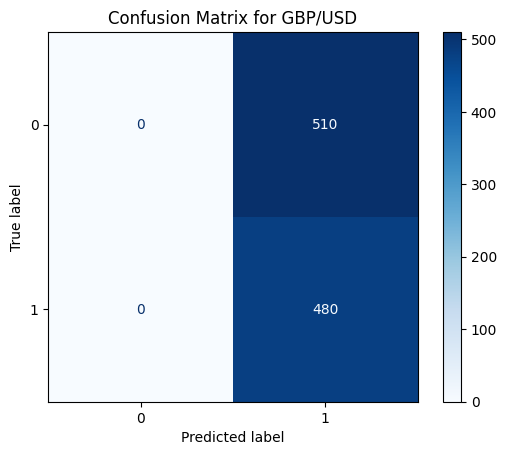

In [65]:
# Generar la matriz de confusión
cm_gbpusd = confusion_matrix(y_test_gbpusd, y_pred_gbpusd)

# Mostrar la matriz de confusión
disp_gbpusd = ConfusionMatrixDisplay(confusion_matrix=cm_gbpusd, display_labels=[0, 1])
disp_gbpusd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for GBP/USD')
plt.show()
